---
In this notebook, we will perform below steps
- Loading SDOH Zipcode data 2019 
- Select only health data variables/labels
- Perform PCA
- Perform Kmeans
- Run Random forest and SHAP

In [1]:
!pip install --upgrade pip --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [2]:
!pip install --upgrade pandas --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [3]:
!pip install --upgrade numpy --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [4]:
# !pip install imbalanced-learn --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple --trusted-host=artifactory.alight.com

In [5]:
# !pip install category_encoders --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple --trusted-host=artifactory.alight.com

In [6]:
conda install shap

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [7]:
#importing librarires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import boto3
import io
import time
import gc
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score,\
roc_auc_score, make_scorer, plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix, average_precision_score,\
ConfusionMatrixDisplay

import tempfile
import boto3
import joblib

# import shap

%matplotlib inline
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

<font color='red'>
We need to edit below cell before running the whole script.
    
If not editted, data will be pulled and stored from S3 bucket as per given values.
</font>

In [8]:
# Mention all file names as string in the below list which are available at "raw_data_path" directory
data_path = f'external/artichauhan'

sdoh_data_path = f'{data_path}/SDOH Health/Data'

demo_data_path = f'{data_path}/Pre-Diabetes/Raw Data/Demographics files'

sdoh_fnames= ['zipcode_2019.csv']

sdoh_fnames2= ['zipcode_2020.csv']

demo_fnames = ['Hype_ML_demographics_19_20_21_1.csv','Hype_ML_demographics_19_20_21_2.csv']

bucket='adl-core-sagemaker-studio'

In [9]:
def load_data_from_s3(bucket,raw_data_path,raw_data_fnames):
    s3 = boto3.client('s3')
    dataset_nrows = []
    for i, fname in enumerate(raw_data_fnames):
        if i==0:
            print(f'Reading file: {fname}')
            key = f'{raw_data_path}/{fname}'
            obj = s3.get_object(Bucket=bucket, Key=key)
            data = pd.read_csv(io.BytesIO(obj['Body'].read()))
            dataset_nrows.append(data.shape[0])
            print(f'\tFile read successfully | Shape: {data.shape}')
        else:
            print(f'Reading file: {fname}')
            key = f'{raw_data_path}/{fname}'
            obj = s3.get_object(Bucket=bucket, Key=key)
            data2 = pd.read_csv(io.BytesIO(obj['Body'].read()))
            data = data.append(data2,ignore_index=True)
            dataset_nrows.append(data2.shape[0])
            print(f'\tFile read successfully | Shape: {data2.shape}')

    if sum(dataset_nrows) == data.shape[0]:
        print(f'Data from all files loaded successfully | Final Shape: {data.shape}')
        return data.copy()
    else:
        print('There is discrepency in numbers')
        print(f'\tTotal number of rows combined in all files: {sum(dataset_nrows)}')
        print(f'\tAfter combining all files total number of rows are: {data.shape[0]}')
        return None

#### Loading SDOH data

In [10]:
sdoh_set = load_data_from_s3(bucket,sdoh_data_path,sdoh_fnames)

Reading file: zipcode_2019.csv
	File read successfully | Shape: (40607, 355)
Data from all files loaded successfully | Final Shape: (40607, 355)


In [11]:
sdoh_set.shape

(40607, 355)

In [12]:
# sdoh_set_20 = load_data_from_s3(bucket,sdoh_data_path,sdoh_fnames2)

In [13]:
# Health Care facilities variables

HCF = ['POS_DIST_ED_ZP'
,'POS_DIST_MEDSURG_ICU_ZP'
,'POS_DIST_TRAUMA_ZP'
,'POS_DIST_PED_ICU_ZP'
,'POS_DIST_OBSTETRICS_ZP'
,'POS_DIST_CLINIC_ZP'
,'POS_DIST_ALC_ZP'
]

In [14]:
# Distance Provider
DP = ['HIFLD_DIST_UC_ZP']

In [15]:
# Health Insurance Status

HIS = ['ACS_PCT_MEDICAID_ANY_ZC'
,'ACS_PCT_MEDICAID_ANY_BELOW64_ZC'
,'ACS_PCT_MEDICARE_ONLY_ZC'
,'ACS_PCT_OTHER_INS_ZC'
,'ACS_PCT_PVT_EMPL_DRCT_ZC'
,'ACS_PCT_PVT_EMPL_DRCT_BELOW64_ZC'
,'ACS_PCT_PRIVATE_ANY_ZC'
,'ACS_PCT_PRIVATE_ANY_BELOW64_ZC'
,'ACS_PCT_PRIVATE_EMPL_ZC'
,'ACS_PCT_PRIVATE_EMPL_BELOW64_ZC'
,'ACS_PCT_PRIVATE_MDCR_ZC'
,'ACS_PCT_PRIVATE_MDCR_35_64_ZC'
,'ACS_PCT_PRIVATE_OTHER_ZC'
,'ACS_PCT_PRIVATE_OTHER_BELOW64_ZC'
,'ACS_PCT_PRIVATE_SELF_ZC'
,'ACS_PCT_PRIVATE_SELF_BELOW64_ZC'
,'ACS_PCT_PUBLIC_ONLY_ZC'
,'ACS_PCT_PUBLIC_OTHER_ZC'
,'ACS_PCT_PUBLIC_OTHER_BELOW64_ZC'
,'ACS_PCT_SELF_MDCR_ABOVE35_ZC'
,'ACS_PCT_TRICARE_VA_ZC'
,'ACS_PCT_TRICARE_VA_BELOW64_ZC'
,'ACS_PCT_UNINSURED_ZC'
,'ACS_PCT_UNINSURED_BELOW64_ZC'
]

In [16]:
# Health Behaviors

HB = ['CDCP_BLOOD_MED_ADULT_C_ZC'
,'CDCP_CHOLES_SCR_ADULT_C_ZC'
,'CDCP_DOCTOR_VISIT_ADULT_C_ZC'
,'CDCP_NO_PHY_ACTV_ADULT_C_ZC'
]

In [17]:
# Health Outcomes

HO = ['CDCP_ARTHRITIS_ADULT_C_ZC'
,'CDCP_ASTHMA_ADULT_C_ZC'
,'CDCP_CHOLES_ADULT_C_ZC'
,'CDCP_KIDNEY_DISEASE_ADULT_C_ZC'
,'CDCP_PULMONARY_ADULT_C_ZC'
]

In [18]:
ZIP = sdoh_set[[
    'YEAR'
   ,'STATEFIPS'
   ,'ZIPCODE'
   ,'ZCTA'
   ,'STATE'
   ,'REGION'
   ,'TERRITORY'
   ,'POINT_ZIP'
]]

In [19]:
data = sdoh_set[[ 
# 'ZIPCODE'
# ,'YEAR'
# ,'STATEFIPS'
# ,'ZCTA'
# ,'STATE'
# ,'REGION'
# ,'TERRITORY'
# ,'POINT_ZIP'
'POS_DIST_ED_ZP'
,'POS_DIST_MEDSURG_ICU_ZP'
,'POS_DIST_TRAUMA_ZP'
,'POS_DIST_PED_ICU_ZP'
,'POS_DIST_OBSTETRICS_ZP'
,'POS_DIST_CLINIC_ZP'
,'POS_DIST_ALC_ZP'
,'ACS_PCT_MEDICAID_ANY_ZC'
,'ACS_PCT_MEDICAID_ANY_BELOW64_ZC'
,'ACS_PCT_MEDICARE_ONLY_ZC'
,'ACS_PCT_OTHER_INS_ZC'
,'ACS_PCT_PVT_EMPL_DRCT_ZC'
,'ACS_PCT_PVT_EMPL_DRCT_BELOW64_ZC'
,'ACS_PCT_PRIVATE_ANY_ZC'
,'ACS_PCT_PRIVATE_ANY_BELOW64_ZC'
,'ACS_PCT_PRIVATE_EMPL_ZC'
,'ACS_PCT_PRIVATE_EMPL_BELOW64_ZC'
,'ACS_PCT_PRIVATE_MDCR_ZC'
,'ACS_PCT_PRIVATE_MDCR_35_64_ZC'
,'ACS_PCT_PRIVATE_OTHER_ZC'
,'ACS_PCT_PRIVATE_OTHER_BELOW64_ZC'
,'ACS_PCT_PRIVATE_SELF_ZC'
,'ACS_PCT_PRIVATE_SELF_BELOW64_ZC'
,'ACS_PCT_PUBLIC_ONLY_ZC'
,'ACS_PCT_PUBLIC_OTHER_ZC'
,'ACS_PCT_PUBLIC_OTHER_BELOW64_ZC'
,'ACS_PCT_SELF_MDCR_ABOVE35_ZC'
,'ACS_PCT_TRICARE_VA_ZC'
,'ACS_PCT_TRICARE_VA_BELOW64_ZC'
,'ACS_PCT_UNINSURED_ZC'
,'ACS_PCT_UNINSURED_BELOW64_ZC'
,'CDCP_BLOOD_MED_ADULT_C_ZC'
,'CDCP_CHOLES_SCR_ADULT_C_ZC'
,'CDCP_DOCTOR_VISIT_ADULT_C_ZC'
,'CDCP_NO_PHY_ACTV_ADULT_C_ZC'
,'CDCP_ARTHRITIS_ADULT_C_ZC'
,'CDCP_ASTHMA_ADULT_C_ZC'
,'CDCP_CHOLES_ADULT_C_ZC'
,'CDCP_KIDNEY_DISEASE_ADULT_C_ZC'
,'CDCP_PULMONARY_ADULT_C_ZC']]

In [20]:
data.shape

(40607, 40)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40607 entries, 0 to 40606
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   POS_DIST_ED_ZP                    39030 non-null  float64
 1   POS_DIST_MEDSURG_ICU_ZP           39028 non-null  float64
 2   POS_DIST_TRAUMA_ZP                39026 non-null  float64
 3   POS_DIST_PED_ICU_ZP               38978 non-null  float64
 4   POS_DIST_OBSTETRICS_ZP            39030 non-null  float64
 5   POS_DIST_CLINIC_ZP                39035 non-null  float64
 6   POS_DIST_ALC_ZP                   39030 non-null  float64
 7   ACS_PCT_MEDICAID_ANY_ZC           40607 non-null  float64
 8   ACS_PCT_MEDICAID_ANY_BELOW64_ZC   40514 non-null  float64
 9   ACS_PCT_MEDICARE_ONLY_ZC          40607 non-null  float64
 10  ACS_PCT_OTHER_INS_ZC              40607 non-null  float64
 11  ACS_PCT_PVT_EMPL_DRCT_ZC          40607 non-null  float64
 12  ACS_

In [22]:
data.head(2)

,POS_DIST_ED_ZP,POS_DIST_MEDSURG_ICU_ZP,POS_DIST_TRAUMA_ZP,POS_DIST_PED_ICU_ZP,POS_DIST_OBSTETRICS_ZP,POS_DIST_CLINIC_ZP,POS_DIST_ALC_ZP,ACS_PCT_MEDICAID_ANY_ZC,ACS_PCT_MEDICAID_ANY_BELOW64_ZC,ACS_PCT_MEDICARE_ONLY_ZC,ACS_PCT_OTHER_INS_ZC,ACS_PCT_PVT_EMPL_DRCT_ZC,ACS_PCT_PVT_EMPL_DRCT_BELOW64_ZC,ACS_PCT_PRIVATE_ANY_ZC,ACS_PCT_PRIVATE_ANY_BELOW64_ZC,ACS_PCT_PRIVATE_EMPL_ZC,ACS_PCT_PRIVATE_EMPL_BELOW64_ZC,ACS_PCT_PRIVATE_MDCR_ZC,ACS_PCT_PRIVATE_MDCR_35_64_ZC,ACS_PCT_PRIVATE_OTHER_ZC,ACS_PCT_PRIVATE_OTHER_BELOW64_ZC,ACS_PCT_PRIVATE_SELF_ZC,ACS_PCT_PRIVATE_SELF_BELOW64_ZC,ACS_PCT_PUBLIC_ONLY_ZC,ACS_PCT_PUBLIC_OTHER_ZC,ACS_PCT_PUBLIC_OTHER_BELOW64_ZC,ACS_PCT_SELF_MDCR_ABOVE35_ZC,ACS_PCT_TRICARE_VA_ZC,ACS_PCT_TRICARE_VA_BELOW64_ZC,ACS_PCT_UNINSURED_ZC,ACS_PCT_UNINSURED_BELOW64_ZC,CDCP_BLOOD_MED_ADULT_C_ZC,CDCP_CHOLES_SCR_ADULT_C_ZC,CDCP_DOCTOR_VISIT_ADULT_C_ZC,CDCP_NO_PHY_ACTV_ADULT_C_ZC,CDCP_ARTHRITIS_ADULT_C_ZC,CDCP_ASTHMA_ADULT_C_ZC,CDCP_CHOLES_ADULT_C_ZC,CDCP_KIDNEY_DISEASE_ADULT_C_ZC,CDCP_PULMONARY_ADULT_C_ZC
0,8.02,11.30,34.64,11.83,8.02,6.82,11.30,60.19,64.82,10.16,2.25,0.13,0.16,19.60,21.36,10.94,13.06,0.62,0.00,0.0,0.0,6.91,8.15,71.42,0.57,0.19,1.00,0.50,0.62,6.72,7.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.69,4.69,5.92,45.09,4.69,12.65,24.76,58.35,59.81,7.14,2.00,0.05,0.06,25.35,27.77,16.54,19.73,2.29,0.47,0.0,0.0,6.19,7.51,66.62,0.69,0.17,0.28,0.44,0.54,6.03,7.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
data.isna().sum()

POS_DIST_ED_ZP                      1577
POS_DIST_MEDSURG_ICU_ZP             1579
POS_DIST_TRAUMA_ZP                  1581
POS_DIST_PED_ICU_ZP                 1629
POS_DIST_OBSTETRICS_ZP              1577
POS_DIST_CLINIC_ZP                  1572
POS_DIST_ALC_ZP                     1577
ACS_PCT_MEDICAID_ANY_ZC                0
ACS_PCT_MEDICAID_ANY_BELOW64_ZC       93
ACS_PCT_MEDICARE_ONLY_ZC               0
ACS_PCT_OTHER_INS_ZC                   0
ACS_PCT_PVT_EMPL_DRCT_ZC               0
ACS_PCT_PVT_EMPL_DRCT_BELOW64_ZC      93
ACS_PCT_PRIVATE_ANY_ZC                 0
ACS_PCT_PRIVATE_ANY_BELOW64_ZC        93
ACS_PCT_PRIVATE_EMPL_ZC                0
ACS_PCT_PRIVATE_EMPL_BELOW64_ZC       93
ACS_PCT_PRIVATE_MDCR_ZC                0
ACS_PCT_PRIVATE_MDCR_35_64_ZC         93
ACS_PCT_PRIVATE_OTHER_ZC               0
ACS_PCT_PRIVATE_OTHER_BELOW64_ZC      93
ACS_PCT_PRIVATE_SELF_ZC                0
ACS_PCT_PRIVATE_SELF_BELOW64_ZC       93
ACS_PCT_PUBLIC_ONLY_ZC                 0
ACS_PCT_PUBLIC_O

In [24]:
data.dropna(inplace=True)

In [25]:
# scaling the data

scaler = StandardScaler()

data_std = scaler.fit_transform(data)

In [26]:
# data_std

In [ ]:
#Dimensionality Reduction with PCA
pca_1 = PCA(11)
pca_1.fit(data_std)

In [28]:
# pca_1.explained_variance_

In [29]:
# cumultative variance plot

pca_1.explained_variance_ratio_

array([2.35086840e-01, 1.29296622e-01, 1.01624001e-01, 7.28309705e-02,
       5.48369990e-02, 4.78840342e-02, 4.42530282e-02, 3.40166278e-02,
       3.12525122e-02, 2.95103319e-02, 2.45284577e-02, 2.43015194e-02,
       2.13387979e-02, 1.98846716e-02, 1.71836224e-02, 1.66026792e-02,
       1.39921546e-02, 1.25474965e-02, 1.22550519e-02, 1.05668600e-02,
       9.89347460e-03, 8.16737402e-03, 6.09818833e-03, 4.87211762e-03,
       3.40725603e-03, 2.90467245e-03, 2.63888108e-03, 2.41991716e-03,
       1.46695795e-03, 1.21953690e-03, 7.43869472e-04, 5.96212700e-04,
       5.39860012e-04, 4.83356432e-04, 4.32150602e-04, 3.22886805e-04,
       5.54558618e-09, 2.02438825e-09, 1.56428914e-09, 4.63627044e-32])

In [30]:
np.cumsum(pca_1.explained_variance_ratio_)

array([0.23508684, 0.36438346, 0.46600746, 0.53883843, 0.59367543,
       0.64155947, 0.6858125 , 0.71982912, 0.75108164, 0.78059197,
       0.80512043, 0.82942194, 0.85076074, 0.87064541, 0.88782904,
       0.90443172, 0.91842387, 0.93097137, 0.94322642, 0.95379328,
       0.96368675, 0.97185413, 0.97795232, 0.98282443, 0.98623169,
       0.98913636, 0.99177524, 0.99419516, 0.99566212, 0.99688165,
       0.99762552, 0.99822174, 0.9987616 , 0.99924495, 0.9996771 ,
       0.99999999, 1.        , 1.        , 1.        , 1.        ])

Text(0, 0.5, 'Cumultative Explained Variance')

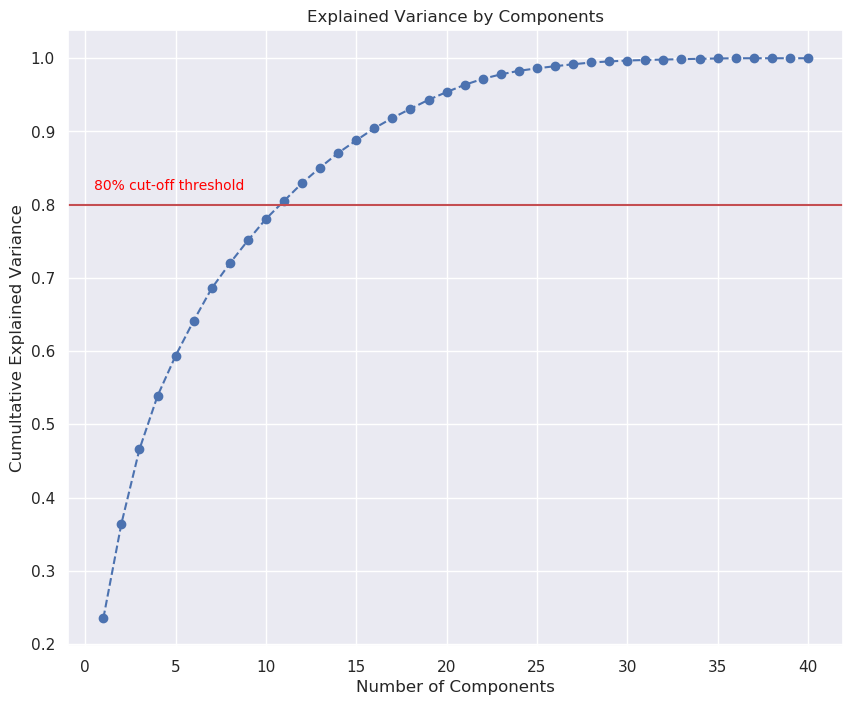

In [31]:
fig = plt.figure(figsize = (10,8))
plt.plot(range(1,41), np.cumsum(pca_1.explained_variance_ratio_), marker = 'o', linestyle = '--')
plt.axhline(y=0.80, color='r', linestyle='-')
plt.text(0.5, 0.82, '80% cut-off threshold', color = 'red', fontsize=10)
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumultative Explained Variance')

In [32]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca_1.components_
num_pc = pca_1.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = data.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
POS_DIST_ED_ZP,0.122962,-0.183150,0.333233,-0.052443,0.127891,0.021578,0.016681,-0.000453,-0.045536,0.002203,-0.018560,0.061277,0.123271,-0.053552,0.046697,0.164726,0.011220,0.205408,-0.276962,-0.013384,-0.111982,-0.037401,-0.072889,-0.330809,-0.161805,-0.601601,-0.349788,-0.091397,0.006802,-0.006808,0.000360,0.007682,0.003638,0.003492,-0.002001,0.001579,1.041835e-05,-4.741274e-06,1.904709e-06,-2.435118e-16
POS_DIST_MEDSURG_ICU_ZP,0.129087,-0.157489,0.322254,-0.068102,0.124383,0.029770,0.011016,-0.015134,-0.034644,-0.011464,0.006304,0.034930,0.080501,-0.017207,0.040980,0.076703,0.059082,0.028734,-0.289327,0.271384,0.339088,0.098207,0.269453,0.671440,-0.054857,0.028523,-0.029110,0.034565,0.027912,-0.004640,0.000177,-0.001669,0.001140,-0.000134,-0.001482,-0.000609,-6.681224e-06,1.961229e-06,-2.931800e-06,-1.278248e-16
POS_DIST_TRAUMA_ZP,0.137257,-0.160650,0.236477,0.013458,0.104922,0.048146,0.006621,-0.045576,0.038667,0.006938,-0.019983,-0.035804,0.012124,-0.085091,-0.121354,-0.241890,-0.050210,0.544571,0.516840,-0.396749,0.215620,-0.046018,0.109442,0.055124,-0.032550,-0.010832,0.096009,-0.007199,0.045937,-0.010493,0.001829,0.000378,0.000047,-0.003657,0.005357,-0.001685,2.974839e-06,2.849267e-06,5.574258e-08,-4.725614e-17
POS_DIST_PED_ICU_ZP,0.130792,-0.142617,0.287450,-0.038008,0.083929,0.039241,0.028239,-0.019002,0.015217,-0.008099,0.061321,-0.093643,-0.125911,0.060862,-0.040037,-0.315866,0.038242,-0.332910,0.239940,0.433921,0.422970,0.114090,-0.223693,-0.355953,0.063039,0.032665,-0.041609,-0.016246,-0.033177,-0.003777,-0.000558,0.001122,0.002814,0.000475,-0.001136,0.002675,3.105266e-06,-7.199452e-06,2.990360e-07,2.953746e-16
POS_DIST_OBSTETRICS_ZP,0.142326,-0.193402,0.302615,-0.034171,0.110975,0.028307,0.008025,-0.014561,-0.019068,-0.005944,-0.035217,0.064211,0.107747,-0.044005,0.073493,0.111704,0.010924,0.227748,-0.377415,-0.039305,-0.135809,-0.010112,-0.206703,-0.279722,0.160592,0.545988,0.362096,0.076547,-0.050361,0.006624,0.001358,-0.007089,-0.002994,-0.002778,-0.002957,-0.000200,-3.417785e-06,3.685753e-06,-1.876769e-06,2.999877e-16
POS_DIST_CLINIC_ZP,0.051226,-0.160272,0.279395,-0.041782,0.115109,-0.009980,0.020066,0.015461,-0.060869,-0.004445,-0.015638,0.049987,0.147426,-0.042585,0.020590,0.563794,0.024228,-0.496689,0.416520,-0.271442,-0.122745,0.095834,0.052539,0.040643,0.050985,0.057510,0.011387,-0.012205,0.014589,-0.006972,-0.000529,-0.003796,0.001366,-0.000383,-0.002071,-0.000038,-1.429328e-06,-9.369693e-07,6.666398e-07,1.788374e-17
POS_DIST_ALC_ZP,0.131374,-0.156049,0.261410,-0.018047,0.041708,0.036292,0.027919,0.015460,-0.001481,-0.013969,0.021024,-0.038242,-0.172729,0.088971,0.025002,-0.487471,-0.036942,-0.161879,0.053965,0.049579,-0.718548,0.058911,0.106430,0.204661,-0.002010,-0.009126,-0.027853,0.003429,-0.016503,0.020459,-0.001628,0.001724,-0.003775,0.002888,0.004219,-0.000438,-6.579984e-06,-1.896008e-07,-2.171270e-06,-7.917237e-17
ACS_PCT_MEDICAID_ANY_ZC,0.232303,0.188006,-0.093509,-0.106776,0.127135,0.104182,0.237957,-0.050727,-0.126849,-0.022757,0.130901,0.065003,0.130332,0.118995,0.085341,-0.029286,0.011591,0.001459,0.026135,-0.022539,0.004759,0.002237,-0.010210,0.001368,0.017111,-0.019775,0.027150,-0.014962,-0.003291,0.321912,-0.083411,-0.025083,0.258690,0.038231,0.107657,0.132907,-3.171228e-01,1.149966e-01,6.032835e-04,-6.334949e-01
ACS_PCT_MEDICAID_ANY_BELOW64_ZC,0.240740,0.158332,-0.099738,-0.079068,0.120496,0.106425,0.260485,-0.036798,-0.157545,0.002602,0.137051,0.047462,0.077910,0.138969,0.018291,-0.007533,-0.027427,0.011923,0.021394,-0.023165,-0.008446,-0.000985,-0.091382,0.041750,0.020252,-0.019270,0.004789,0.015353,0.003106,-0.242956,0.056361,0.009728,-0.468382,0.000611,-0.658745,0.073197,-7.570442e-06,-1.291393e-05,8.495746e-06,-7.257980e-16


In [33]:
# print(abs( pca_1.components_ ))

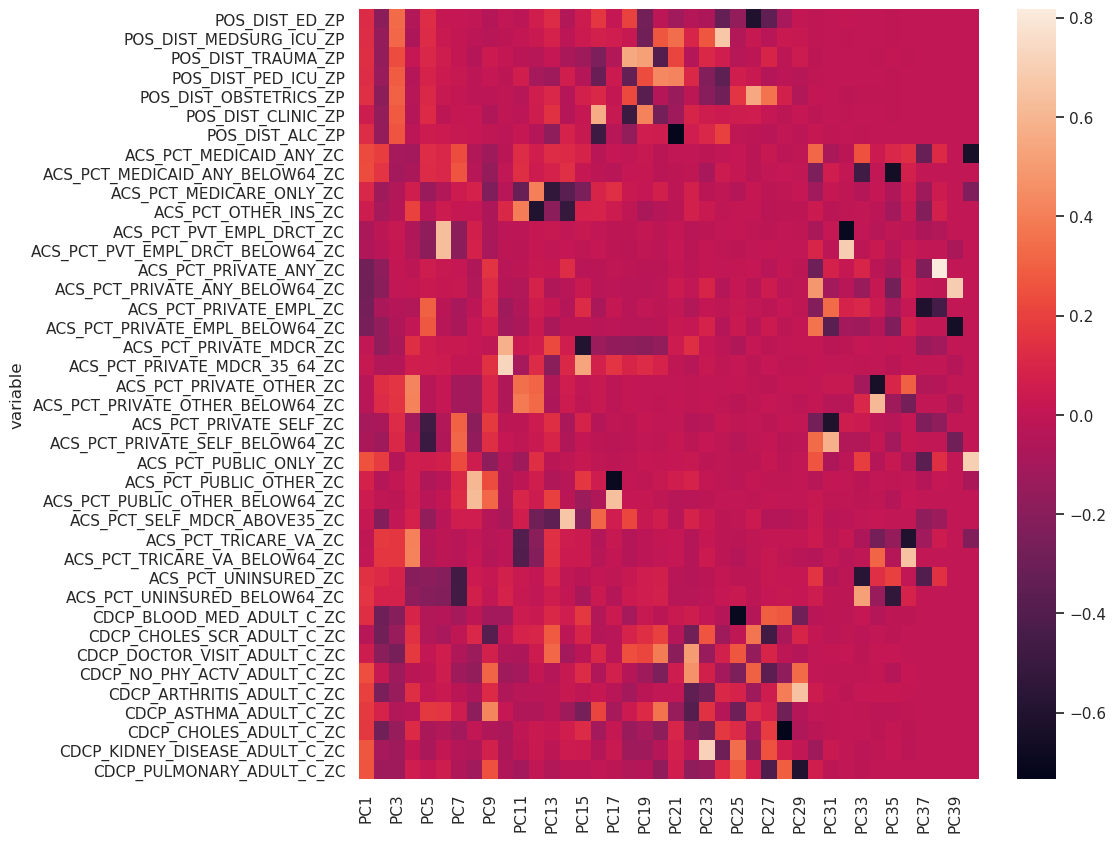

In [34]:
# positive and negative values in component loadings reflects the positive and negative 
# correlation of the variables with the PCs. Except A and B, all other variables have 
# positive projection on first PC.
# get correlation matrix plot for loadings
fig = plt.figure(figsize = (10,10))
ax = sns.heatmap(loadings_df)
plt.show()

The graph shows the amount of variance captured (on the y-axis) depending on the number of components we include (the x-axis). A rule of thumb is to preserve around 80 % of the variance. So, in this instance, we decide to keep 11 components.

In [35]:
# PCA with chosen number of components
pca = PCA(n_components=0.80)

In [36]:
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [37]:
pca.transform(data)

array([[-3.44206891e+01, -1.39271307e+01, -4.21698433e-01,
        -4.79654321e+00,  2.05523137e+00],
       [-2.39285352e+01,  1.41284945e+01, -1.86963593e+00,
        -4.33582580e+00, -2.60161564e+00],
       [-2.72135050e+01,  1.16312653e+01, -1.59770394e+00,
        -3.26887504e+00,  2.13561752e-01],
       ...,
       [ 3.29291726e+02,  2.64391458e+02,  2.17227131e+02,
        -3.40814674e+00, -2.20789050e+01],
       [ 3.63996201e+02,  2.33644805e+02,  2.12044594e+02,
         2.37235680e+00, -2.50939005e+01],
       [ 3.49792392e+02,  2.75701440e+02,  1.92641454e+02,
         3.69211163e+00, -3.05862536e+01]])

In [38]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.42844725, 0.26666889, 0.05906525, 0.04563829, 0.04072551])

In [39]:
explained_variance = np.insert(explained_variance, 0, 0)

In [40]:
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=3))

In [41]:
pc_df = pd.DataFrame(['','PC1', 'PC2', 'PC3','PC4','PC5'], columns=['PC'])
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])

In [42]:
df_explained_variance = pd.concat([pc_df, explained_variance_df, cumulative_variance_df], axis=1)
df_explained_variance

,PC,Explained Variance,Cumulative Variance
0,,0.000000,0.000
1,PC1,0.428447,0.428
2,PC2,0.266669,0.695
3,PC3,0.059065,0.754
4,PC4,0.045638,0.800
5,PC5,0.040726,0.841


In [43]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = data.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5
variable,,,,,
POS_DIST_ED_ZP,0.141834,0.111890,-0.197761,-0.035781,-0.134956
POS_DIST_MEDSURG_ICU_ZP,0.228397,0.166777,-0.128744,-0.051798,-0.251582
POS_DIST_TRAUMA_ZP,0.268358,0.172178,-0.475433,-0.280004,-0.470082
POS_DIST_PED_ICU_ZP,0.595926,0.460012,0.634807,0.011068,-0.013962
POS_DIST_OBSTETRICS_ZP,0.162899,0.112237,-0.242060,-0.040969,-0.126609
POS_DIST_CLINIC_ZP,0.064508,0.081972,-0.064740,-0.008743,-0.089814
POS_DIST_ALC_ZP,0.329361,0.227604,-0.447265,0.124606,0.762127
ACS_PCT_MEDICAID_ANY_ZC,0.137460,-0.241135,0.081065,-0.337798,0.104318
ACS_PCT_MEDICAID_ANY_BELOW64_ZC,0.162427,-0.265372,0.072501,-0.388850,0.132087


In [44]:
loadings_df.sort_values(['PC1'], ascending=[False])

,PC1,PC2,PC3,PC4,PC5
variable,,,,,
POS_DIST_PED_ICU_ZP,0.595926,0.460012,0.634807,0.011068,-0.013962
POS_DIST_ALC_ZP,0.329361,0.227604,-0.447265,0.124606,0.762127
POS_DIST_TRAUMA_ZP,0.268358,0.172178,-0.475433,-0.280004,-0.470082
POS_DIST_MEDSURG_ICU_ZP,0.228397,0.166777,-0.128744,-0.051798,-0.251582
ACS_PCT_PUBLIC_ONLY_ZC,0.172357,-0.268566,0.037006,-0.274022,0.097463
POS_DIST_OBSTETRICS_ZP,0.162899,0.112237,-0.242060,-0.040969,-0.126609
ACS_PCT_MEDICAID_ANY_BELOW64_ZC,0.162427,-0.265372,0.072501,-0.388850,0.132087
POS_DIST_ED_ZP,0.141834,0.111890,-0.197761,-0.035781,-0.134956
ACS_PCT_MEDICAID_ANY_ZC,0.137460,-0.241135,0.081065,-0.337798,0.104318


In [45]:
scores_pca = pca.transform(data)

Combining PCA scores in the K-means algorithm. 

In [46]:
# We fit K-Means using the transformed data with PCA
wcss = []
for i in range(1,15):
    kmeans_pca = KMeans(n_clusters=i, init = 'k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

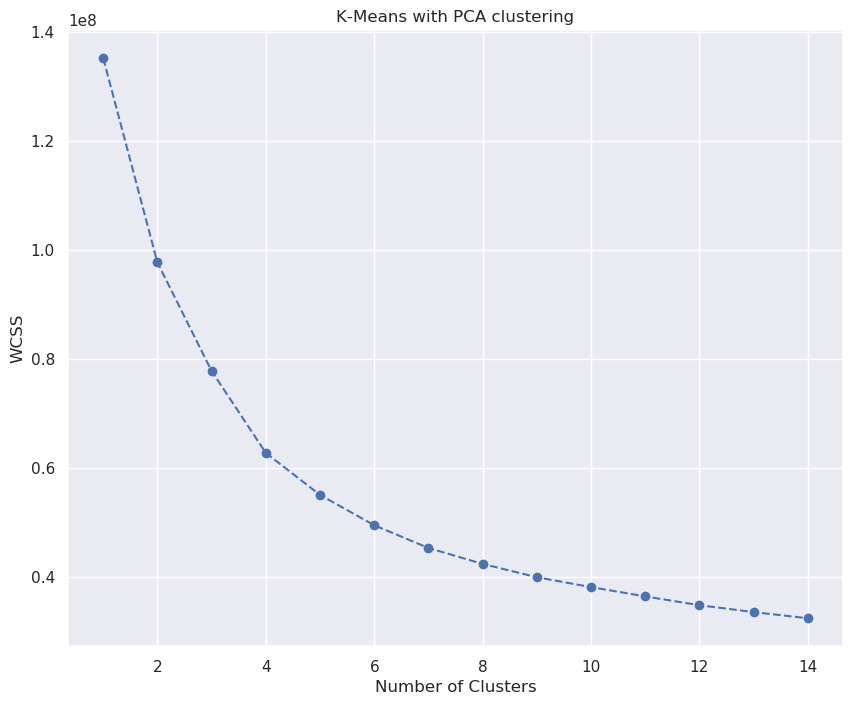

In [47]:
# plotting above wcss against number of components

plt.figure(figsize = (10,8))
plt.plot(range(1,15),wcss,marker='o',linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-Means with PCA clustering')
plt.show()

In [48]:
# We choose 4 clusters from above graph

kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state=42)

In [49]:
kmeans_pca.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [50]:
new_data = data

In [51]:
# # Analyzing Results
# # We create a new dataframe with the original features and add the PCA scires and assigned clusters

# new_data = pd.concat([data.reset_index(drop=True),pd.DataFrame(scores_pca)], axis=1)
# new_data.columns.values[-5: ] = ['Component 1','Component 2','Component 3','Component 4','Component 5']

In [52]:
# cluster column
new_data['Clusters'] = kmeans_pca.labels_

In [53]:
# new_data.columns

In [54]:
new_data.head(2)

,POS_DIST_ED_ZP,POS_DIST_MEDSURG_ICU_ZP,POS_DIST_TRAUMA_ZP,POS_DIST_PED_ICU_ZP,POS_DIST_OBSTETRICS_ZP,POS_DIST_CLINIC_ZP,POS_DIST_ALC_ZP,ACS_PCT_MEDICAID_ANY_ZC,ACS_PCT_MEDICAID_ANY_BELOW64_ZC,ACS_PCT_MEDICARE_ONLY_ZC,ACS_PCT_OTHER_INS_ZC,ACS_PCT_PVT_EMPL_DRCT_ZC,ACS_PCT_PVT_EMPL_DRCT_BELOW64_ZC,ACS_PCT_PRIVATE_ANY_ZC,ACS_PCT_PRIVATE_ANY_BELOW64_ZC,ACS_PCT_PRIVATE_EMPL_ZC,ACS_PCT_PRIVATE_EMPL_BELOW64_ZC,ACS_PCT_PRIVATE_MDCR_ZC,ACS_PCT_PRIVATE_MDCR_35_64_ZC,ACS_PCT_PRIVATE_OTHER_ZC,ACS_PCT_PRIVATE_OTHER_BELOW64_ZC,ACS_PCT_PRIVATE_SELF_ZC,ACS_PCT_PRIVATE_SELF_BELOW64_ZC,ACS_PCT_PUBLIC_ONLY_ZC,ACS_PCT_PUBLIC_OTHER_ZC,ACS_PCT_PUBLIC_OTHER_BELOW64_ZC,ACS_PCT_SELF_MDCR_ABOVE35_ZC,ACS_PCT_TRICARE_VA_ZC,ACS_PCT_TRICARE_VA_BELOW64_ZC,ACS_PCT_UNINSURED_ZC,ACS_PCT_UNINSURED_BELOW64_ZC,CDCP_BLOOD_MED_ADULT_C_ZC,CDCP_CHOLES_SCR_ADULT_C_ZC,CDCP_DOCTOR_VISIT_ADULT_C_ZC,CDCP_NO_PHY_ACTV_ADULT_C_ZC,CDCP_ARTHRITIS_ADULT_C_ZC,CDCP_ASTHMA_ADULT_C_ZC,CDCP_CHOLES_ADULT_C_ZC,CDCP_KIDNEY_DISEASE_ADULT_C_ZC,CDCP_PULMONARY_ADULT_C_ZC,Clusters
170,3.38,3.38,3.52,3.52,3.38,2.76,3.38,17.02,21.08,4.19,7.95,1.92,2.46,65.95,67.05,45.69,57.78,4.95,0.13,0.00,0.00,5.31,6.68,22.37,0.11,0.0,8.08,1.05,1.34,3.72,4.77,77.9,91.8,80.7,26.6,30.0,10.4,31.9,3.0,6.9,0
171,9.24,9.24,21.06,21.06,9.24,2.86,12.85,14.47,16.01,2.33,6.09,3.68,4.24,73.80,76.56,52.93,59.76,4.87,0.17,0.08,0.09,10.75,12.31,17.36,0.10,0.0,1.49,0.46,0.53,2.74,3.12,64.2,83.1,76.9,25.8,17.6,11.1,19.2,2.2,5.0,0


In [55]:
# # Creating a new column name cluster and map all the clusters in it
# new_data['segment'] = new_data['Clusters'].map{0:'First',
#                                               1:'Second',
#                                               2:'Third',
#                                               3:'Fourth'}



In [56]:
new_data['Clusters'].value_counts()

0    18305
1    11219
3     8196
2      112
Name: Clusters, dtype: int64

In [57]:
new_data['Clusters'].value_counts(normalize=True)

0    0.483850
1    0.296548
3    0.216642
2    0.002960
Name: Clusters, dtype: float64

In [58]:
# # Plot data by PCA Components. The Y axis is the first component and X axis is the second

# x_axis = new_data['Component 2']
# y_axis = new_data['Component 1']
# plt.figure(figsize = (10,8))
# sns.scatterplot(x_axis, y_axis, hue= new_data['Clusters'], palette = ['g','r','c','m'])
# plt.title('Clusters by PCA Components')
# plt.show()

Performing Supervised Learning using Clusters as target

In [59]:
#Split train-test data
from sklearn.model_selection import train_test_split

train_set,test_set = train_test_split(new_data, test_size = 0.20, 
                                   stratify=new_data['Clusters'],shuffle=True, random_state=42)


In [60]:
train_set.shape

(30265, 41)

In [61]:
train_X = train_set.drop(['Clusters'],axis=1)
train_y = train_set['Clusters']

In [62]:
test_X = test_set.drop(['Clusters'],axis=1)
test_y = test_set['Clusters']

In [63]:
%%time
rf = RandomForestClassifier(n_estimators = 10, random_state = 42)

rf = rf.fit(train_X, train_y)

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.03 s


In [64]:
pred_rf  = rf.predict(test_X)

In [65]:
test_y.value_counts()

0    3661
1    2244
3    1639
2      23
Name: Clusters, dtype: int64

In [66]:
# Making the Confusion Matrix
print(pd.crosstab(test_y, pred_rf, rownames=['Actual'], colnames=['Predicted']))

Predicted     0     1   2     3
Actual                         
0          3611    15   0    35
1            41  2149   0    54
2             0     0  21     2
3           117   117   0  1405


In [67]:
print(list(zip(test_X.columns[0:4], rf.feature_importances_)))

[('POS_DIST_ED_ZP', 0.010941093206018168), ('POS_DIST_MEDSURG_ICU_ZP', 0.03998261218753548), ('POS_DIST_TRAUMA_ZP', 0.023343158255632452), ('POS_DIST_PED_ICU_ZP', 0.16836107261071173)]


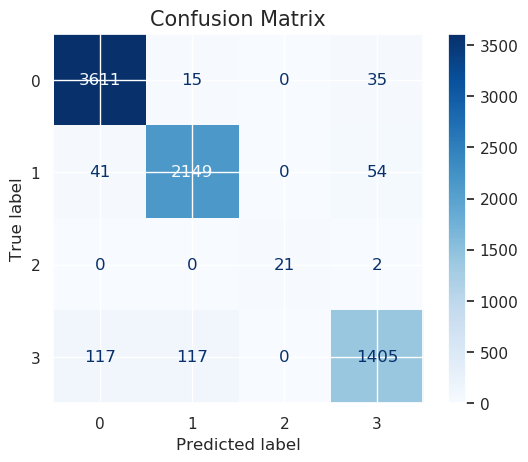

In [68]:
plot_confusion_matrix(estimator=rf, X=test_X, y_true=test_y, cmap='Blues',values_format='.0f')
plt.title('Confusion Matrix', size=15)
# plt.savefig('Confusion Matrix.png')
plt.show()

In [69]:
#Get the confusion matrix
cf_matrix = confusion_matrix(test_y, pred_rf)
print(cf_matrix)

[[3611   15    0   35]
 [  41 2149    0   54]
 [   0    0   21    2]
 [ 117  117    0 1405]]


In [70]:
round(test_y.value_counts(normalize=True),2)

0    0.48
1    0.30
3    0.22
2    0.00
Name: Clusters, dtype: float64

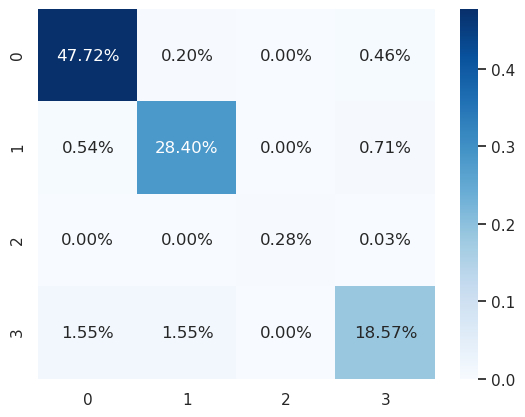

In [71]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [72]:
print("RandonForestClassifier:\n", classification_report(test_y, pred_rf))

RandonForestClassifier:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      3661
           1       0.94      0.96      0.95      2244
           2       1.00      0.91      0.95        23
           3       0.94      0.86      0.90      1639

    accuracy                           0.95      7567
   macro avg       0.96      0.93      0.94      7567
weighted avg       0.95      0.95      0.95      7567



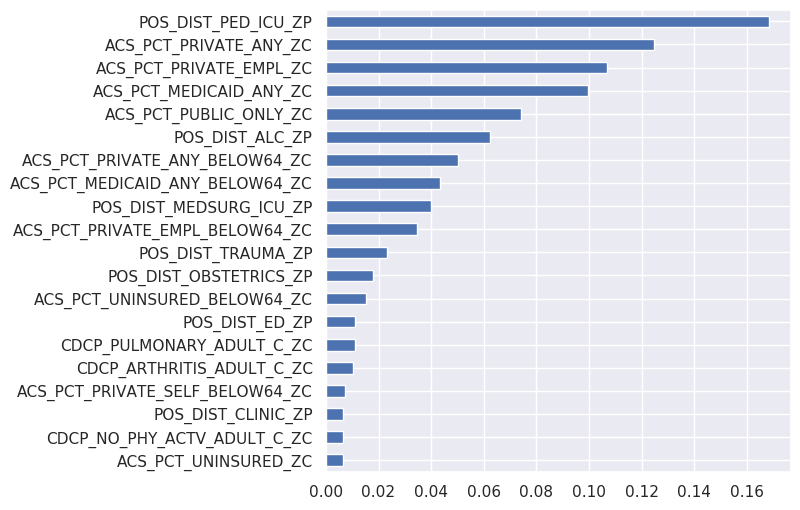

In [73]:
pd.Series(rf.feature_importances_, index=train_X.columns).sort_values(ascending=True)[-20:].plot(kind='barh', figsize=(6,6))

## Using SHAP values to interpret the model

In [74]:
import shap

In [75]:
X = new_data.drop(['Clusters'],axis=1)
y = new_data['Clusters']

In [76]:
# compute SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

KeyboardInterrupt: 

In [ ]:
pred_prob = rf.predict(X)

In [ ]:
pred_prob.mean()

In [ ]:
# shap_values.base_values

In [ ]:
# shap.initjs()
# shap.plots.force(shap_values.base_values[5],shap_values.values[5], feature_names=test_X.columns)

In [ ]:
# shap.plots.force(shap_values.base_values[2],shap_values.values[2], feature_names=test_X.columns)

In [ ]:
class_names = [0,1,2,3]

In [ ]:
shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= class_names, feature_names = X.columns)

In [ ]:
shap.summary_plot(shap_values[0], X.values, feature_names = X.columns)

In [ ]:
shap.summary_plot(shap_values[1], X.values, feature_names = X.columns)

In [ ]:
shap.summary_plot(shap_values[2], X.values, feature_names = X.columns)

In [ ]:
shap.summary_plot(shap_values[3], X.values, feature_names = X.columns)

In [ ]:
# plot_df = pd.DataFrame(shap_df.abs().mean(axis=0), columns=['mean(|SHAP values|)'])
# plot_df['corr_coef'] = corr_coef
# plot_df['corr color'] = color_list
# plot_df = plot_df.sort_values('mean(|SHAP values|)', ascending=True).reset_index()
# plot_df = plot_df.iloc[-10:,:]
# colorlist = plot_df['corr color']

In [ ]:
# # f = plt.figure()
# plot_df.plot.barh(x='index', y='mean(|SHAP values|)',color=colorlist, figsize=(5,6), legend=False)
# plt.xlabel("mean(|SHAP Value|) (Blue = Positive Impact)")
# plt.ylabel('')
# plt.savefig('shap.png',bbox_inches='tight', dpi=600)
# plt.show()

In [ ]:
f = plt.figure()
shap.summary_plot(shap_values[0],plot_type="bar",feature_names = X[:2000].columns)
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

In [ ]:
f = plt.figure()
shap.summary_plot(shap_values[1],plot_type="bar",feature_names = X[:2000].columns)
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

In [ ]:
f = plt.figure()
shap.summary_plot(shap_values[2],plot_type="bar",feature_names = X[:2000].columns)
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

In [ ]:
f = plt.figure()
shap.summary_plot(shap_values[3],plot_type="bar",feature_names = X[:2000].columns)
# f.savefig('shap.png',bbox_inches='tight', dpi=600)